# Convolutional Neural Network Explainability on **MNIST**


## MNIST classification task

The MNIST data set is a database of handwritten digits that is commonly used for training various image processing systems. The goal if this task is to implement a classifier of handwritten digits using neural networks.

![Mnist data set](https://github.com/jirimaterna/image-processing-2days/blob/master/images/mnist-examples.png?raw=1)

## Load the data

The data is already shuffled and split to train and test parts.

In [ ]:
%tensorflow_version 2.x
import pickle
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train original shape: {}".format(X_train.shape))
print("y_train original shape: {}".format(y_train.shape))
print("X_test original shape: {}".format(X_test.shape))
print("y_test original shape: {}".format(y_test.shape))

## Transform the data

We need to scale the input values to have the range (0,1).

In [2]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [3]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
print("X_train matrix shape: {}".format(X_train.shape))
print("X_test matrix shape: {}".format(X_test.shape))

X_train matrix shape: (60000, 28, 28, 1)
X_test matrix shape: (10000, 28, 28, 1)


Transform the targets into one-hot encoding, i.e.
```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
etc.

In [4]:
from tensorflow.python.keras.utils import np_utils

n_classes = 10
y_train = np_utils.to_categorical(y_train, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

## Architecture definition

Create a sequential model and define its structure.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1, ), name='conv1_layer'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(5, 5),  name='conv2_layer'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, name='last_layer'))
model.add(Activation('softmax'))
print(model.summary())

Compile the model.

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train the model

In [ ]:
model.fit(X_train, y_train,
          batch_size = 128, epochs = 10, verbose=1,
          validation_data=(X_test, y_test))

## Evaluate the model

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print ("Test accuracy: {:.4f}".format(accuracy_score(y_test_class, y_pred_class)))
print ()
print(classification_report(y_test_class, y_pred_class, digits=4))

## Activation Maximization

Import dependencies

In [10]:
import numpy as np
import skimage.io as io
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
from matplotlib import pyplot as plt
%matplotlib inline

## Visualize activations of the classification layer

In [11]:
layer = model.get_layer(name="last_layer")
feature_extractor = Model(inputs=model.inputs, outputs=layer.output)

In [12]:
#define the loss function
def compute_loss(input_image, filter_index, model):
    activation = model(input_image)
    filter_activation = activation[..., filter_index]
    return tf.reduce_mean(filter_activation)

In [13]:
#define one learning step
import tensorflow as tf
@tf.function
def learning_step(img, filter_index, model, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index, model)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [14]:
# We start from a gray image with some random noise
def initialize_image():
    img = tf.random.uniform((1, 28, 28, 1)) * 0.25
    return img

In [15]:
def deprocess_image(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15
    img = np.clip(img, 0, 1)
    img *= 255
    img = -np.clip(img, 0, 255).astype("uint8") + 255
    return img

In [16]:
# Run the training algorithm
def visualize_filter(filter_index, model):
    iterations = 100
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = learning_step(img, filter_index, model, learning_rate)
    print ("Training step {}, loss: {}".format(iteration+1, loss))
    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

Training step 100, loss: 5497.37109375


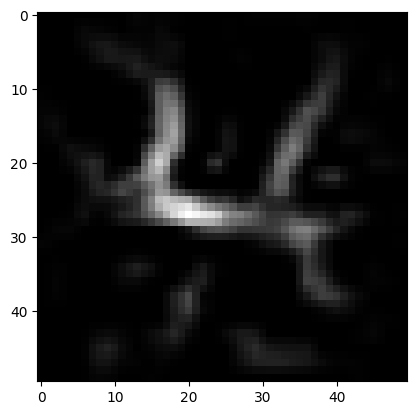

In [17]:
#visualize number 4
class_number = 4
loss, img = visualize_filter(class_number, feature_extractor)
keras.preprocessing.image.save_img("{}.png".format(class_number), img)
source = io.imread("{}.png".format(class_number), as_gray=True)
source = cv2.resize(source, (50, 50))
plt.imshow(source, cmap='Greys')
plt.show()


## Now visualize some filters of the convolutional layers

Training step 100, loss: 306.9176025390625


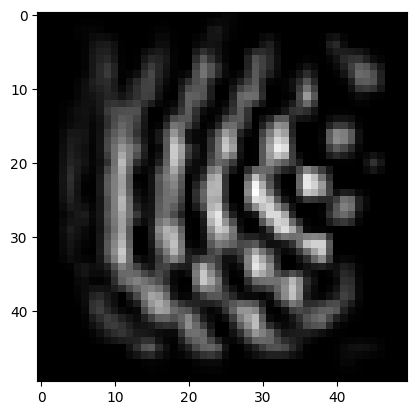

In [18]:
conv_layer = model.get_layer(name="conv2_layer")
conv_feature_extractor = Model(inputs=model.inputs, outputs=conv_layer.output)

filter_number = 10
loss, img = visualize_filter(filter_number, conv_feature_extractor)
keras.preprocessing.image.save_img("{}.png".format(class_number), img)
source = io.imread("{}.png".format(class_number), as_gray=True)
source = cv2.resize(source, (50, 50))
plt.imshow(source, cmap='Greys')
plt.show()